In [1]:
import numpy as np
import pandas as pd

def generate_credit_transition_matrix_with_withdraw_prob(withdraw_prob, main_diagonal_probs):
    n_ratings = 10
    n_columns = 12  # Including withdraw and default columns
    matrix = np.zeros((n_ratings, n_columns))
    
    stddev = withdraw_prob / 10
    
    # Specified default rates
    default_rates = np.array([0.00005, 0.0001, 0.0004, 0.0009, 0.0025, 
                              0.007, 0.0128, 0.0601, 0.1575, 0.3537])

    for i in range(n_ratings):
        # Assign specified default probability
        default_prob = default_rates[i]
        
        # Assign withdraw probability following a normal distribution centered around withdraw_prob
        withdraw_prob_sample = np.random.normal(withdraw_prob, stddev)
        
        # Ensure withdraw probability is within the valid range [0, 1]
        withdraw_prob_sample = max(0, min(withdraw_prob_sample, 1))
        
        # Calculate the remaining probability for other transitions
        remaining_prob = 1 - default_prob - withdraw_prob_sample
        
        # Set main diagonal probability
        main_diagonal = np.random.normal(main_diagonal_probs[i], main_diagonal_probs[i]/100)
        
        # Calculate side probabilities based on the number of adjacent ratings
        num_adjacent_ratings = min(i, n_ratings - 1 - i)
        if i == 0:  # Top rating
            side_prob = (remaining_prob - main_diagonal) / 2  # Only two adjacent ratings (downwards)
        elif i == 9:  # Bottom rating
            side_prob = (remaining_prob - main_diagonal) / 2  # Only two adjacent ratings (upwards)
        elif num_adjacent_ratings == 1:
            side_prob = (remaining_prob - main_diagonal) / 3
        elif num_adjacent_ratings == 2:
            side_prob = (remaining_prob - main_diagonal) / 4
        elif num_adjacent_ratings == 3:
            side_prob = (remaining_prob - main_diagonal) / 5
        else:
            side_prob = (remaining_prob - main_diagonal) / 6
        
        # Set main diagonal
        matrix[i, i] = main_diagonal
        
        # Set probabilities for adjacent ratings with randomness
        for j in range(1, 4):
            if i - j >= 0:  # Lower adjacent ratings, i.e. higher ratings
                matrix[i, i - j] = max(0, side_prob * (4 - j) * np.random.uniform(0.7, 0.9))
            if i + j < n_ratings:  # Upper adjacent ratings, i.e. lower ratings
                matrix[i, i + j] = max(0, side_prob * (4 - j) * np.random.uniform(1.1, 1.3))
        
        # Normalize probabilities for other states while keeping main diagonal fixed
        before_i = np.sum(matrix[i, :i])
        after_i = np.sum(matrix[i, i+1:n_ratings])
        total_adjacent_prob = before_i + after_i
        if total_adjacent_prob > 0:
            matrix[i, :i] *= (remaining_prob - main_diagonal) / total_adjacent_prob
            matrix[i, i+1:n_ratings] *= (remaining_prob - main_diagonal) / total_adjacent_prob
        
        matrix[i, -2] = withdraw_prob_sample  # Withdraw probability
        matrix[i, -1] = default_prob  # Default probability

    # Ensure transition probabilities for Rating 1 and Rating 10 are correctly adjusted
    matrix[0, 1] = max(matrix[0, 1], 1e-5)  # Ensure non-zero probability to transition to Rating 2
    matrix[0, 2] = max(matrix[0, 2], 1e-5)  # Ensure non-zero probability to transition to Rating 3
    matrix[9, 8] = max(matrix[9, 8], 1e-5)  # Ensure non-zero probability to transition to Rating 9
    matrix[9, 7] = max(matrix[9, 7], 1e-5)  # Ensure non-zero probability to transition to Rating 8
    
    # Define row and column labels
    row_labels = [f'Rating {i+1}' for i in range(10)]
    column_labels = [f'Rating {i+1}' for i in range(10)] + ['Withdraw', 'Default']

    # Create a DataFrame with labels
    transition_matrix_df = pd.DataFrame(matrix, index=row_labels, columns=column_labels)

    return matrix, transition_matrix_df

# Example usage
withdraw_prob = 0.05  # Centered around value% withdraw probability
# Main diagonal probabilities for each rating
main_diagonal_probs = [0.88, 0.85, 0.83, 0.82, 0.80, 0.77, 0.70, 0.65, 0.60, 0.55]
matrix, transition_matrix_df = generate_credit_transition_matrix_with_withdraw_prob(withdraw_prob, main_diagonal_probs)
transition_matrix_df

,Rating 1,Rating 2,Rating 3,Rating 4,Rating 5,Rating 6,Rating 7,Rating 8,Rating 9,Rating 10,Withdraw,Default
Rating 1,0.892738,0.029549,0.018561,0.009168,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.049934,0.00005
Rating 2,0.026396,0.852081,0.036993,0.022525,0.011661,0.000000,0.000000,0.000000,0.000000,0.000000,0.050243,0.00010
Rating 3,0.017777,0.027381,0.824435,0.041576,0.028511,0.014307,0.000000,0.000000,0.000000,0.000000,0.045613,0.00040
Rating 4,0.007918,0.014571,0.023915,0.823758,0.034388,0.025946,0.011519,0.000000,0.000000,0.000000,0.057085,0.00090
Rating 5,0.000000,0.011591,0.019560,0.028990,0.787852,0.049496,0.031762,0.016042,0.000000,0.000000,0.052207,0.00250
Rating 6,0.000000,0.000000,0.012219,0.023430,0.031925,0.774417,0.048030,0.036471,0.018433,0.000000,0.048074,0.00700
Rating 7,0.000000,0.000000,0.000000,0.017167,0.026954,0.048882,0.705361,0.066588,0.049543,0.023023,0.049683,0.01280
Rating 8,0.000000,0.000000,0.000000,0.000000,0.016126,0.033902,0.058008,0.646616,0.076575,0.053365,0.055308,0.06010
Rating 9,0.000000,0.000000,0.000000,0.000000,0.000000,0.019664,0.038804,0.050873,0.599228,0.083738,0.050192,0.15750
Rating 10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009812,0.016612,0.027736,0.546935,0.045205,0.35370


In [5]:
from scipy.stats import multinomial

def simu_tm_multiyear(obligor, transition_matrix, year):
    n_ratings, n_columns = transition_matrix.shape
    mat = []
    tm = []
    tm_hf = []
    for i in range(year):
        mat.append(np.zeros((n_ratings, n_columns)))
        tm.append(np.zeros((n_columns, n_columns)))
        tm[i][n_columns - 1,n_columns - 1] = 1
        tm[i][n_columns - 2,n_columns - 2] = 1
        tm_hf.append(np.zeros((n_columns-1, n_columns-1)))
        tm_hf[i][n_columns - 2,n_columns - 2] = 1
        tm_hf[i][n_columns - 3,n_columns - 3] = 1       
    df_multiyear = np.zeros((n_ratings, year))
    wd_multiyear = np.zeros((n_ratings, year))
    for i in range(n_ratings):
        n = np.count_nonzero(obligor == i+1)
        mat[0][i,:] = multinomial.rvs(n, transition_matrix[i,:])
        tm[0][i,:] =  mat[0][i,:]/n
        tm_hf[0][i,:-1] = mat[0][i,:-2]/sum(mat[0][i,:-2])*(sum(mat[0][i,:-2])+mat[0][i,-2]/2)/(n - mat[0][i,-2]/2)
        tm_hf[0][i,-1] = 1 - sum(tm_hf[0][i,:-1])
   
    df_multiyear[:,0] = mat[0][:,-1]
    wd_multiyear[:,0] = mat[0][:,-2]  
    if year > 1:
        for j in range(1,year):
            for i in range(n_ratings):
                n = sum(mat[j - 1][:,i])
                if n > 0:
                    mat[j][i,:] = multinomial.rvs(n, transition_matrix[i,:])
                    tm[j][i,:] = mat[j][i,:]/n
                    tm_hf[j][i,:-1] = mat[j][i,:-2]/sum(mat[j][i,:-2])*(sum(mat[j][i,:-2])+mat[j][i,-2]/2)/(n - mat[j][i,-2]/2)
                    tm_hf[j][i,-1] = 1 - sum(tm_hf[j][i,:-1])
            df_multiyear[:,j] = mat[j][:,-1]
            wd_multiyear[:,j] = mat[j][:,-2]         
    return mat, tm, tm_hf, df_multiyear, wd_multiyear

In [6]:
def forward_tm_multiyear(tm_long_run, year):
    # TTC matrix to cumulative TM
    n_ratings, n_columns = tm_long_run.shape
    ctm_fwd = []
    ctm_fwd.append(tm_long_run)
    tm_long_run_hf = np.zeros((n_columns-1, n_columns-1))
    tm_long_run_hf[:-1,:-1] = tm_long_run[:-2,:-2]/np.sum(tm_long_run[:-2,:-2],0)*(np.sum(tm_long_run[:-2,:-2],0)+tm_long_run[:-2,-2]/2)/(1 - tm_long_run[:-2,-2]/2)
    tm_long_run_hf[:-1,-1] = tm_long_run[:-2,-1]/(1 - tm_long_run[:-2,-2]/2)
    tm_long_run_hf[-1,-1] = 1
    ctm_fwd_hf = []
    ctm_fwd_hf.append(tm_long_run_hf)   
    for j in range(year):
        ctm_fwd.append(np.zeros((n_columns, n_columns)))
        ctm_fwd[j+1] = np.matmul(ctm_fwd[j],tm_long_run)
        ctm_fwd_hf.append(np.zeros((n_columns-1, n_columns-1)))
        ctm_fwd_hf[j+1] = np.matmul(ctm_fwd_hf[j],tm_long_run_hf)       
    return ctm_fwd, ctm_fwd_hf

In [111]:
n_ratings = 10
withdraw_prob = 0.05# Centered around value% withdraw probability
# Main diagonal probabilities for each rating
main_diagonal_probs = [0.83, 0.81, 0.77, 0.74, 0.70, 0.67, 0.63, 0.60, 0.56, 0.52]
#main_diagonal_probs = [0.85, 0.85, 0.83, 0.82, 0.80, 0.77, 0.70, 0.65, 0.60, 0.55]
tm, tm_df = generate_credit_transition_matrix_with_withdraw_prob(withdraw_prob, main_diagonal_probs)

n_obligors = [100000, 200000, 300000, 500000,500000, 400000,300000,20000,10000,5000]
a = np.repeat(range(1,11),n_obligors)
year = 10

multi_mat, multi_tm, multi_tm_hf, multi_df, multi_wd = simu_tm_multiyear(a, tm, year+1)

# PD_2 = (2_year_CPD - 1_year_PD)/(1-1_year_WR), conditional marginal PD

PD = np.zeros((n_ratings, year+1))
WD = np.zeros((n_ratings, year+1))
oblg_rm = np.zeros((n_ratings, year+1))
PD[:,0] = multi_tm[0][:-2,-1]
WD[:,0] = multi_tm[0][:-2,-2]
oblg_rm[:,0] = n_obligors
ctm = multi_tm.copy()

## Case 1

In [70]:
## Case 1, this test is to try to find the most accurate way in theory.
# assume all WD customers only leaves at the end of each periods and assume LGD = 1 EAD = 1
for j in range(1,year+1):
    ctm[j] = np.matmul(ctm[j-1],multi_tm[j])
    PD[:,j] = (ctm[j][:-2,-1] - ctm[j-1][:-2,-1])/(1-ctm[j-1][:-2,-2])
    WD[:,j] = (ctm[j][:-2,-2] - ctm[j-1][:-2,-2])/(1-ctm[j-1][:-2,-2])
    oblg_rm[:,j] = oblg_rm[:,j-1] * (1 - WD[:,j])

t=9
print(sum(PD[:,:t]*oblg_rm[:,:t]),sum(multi_df[:,:t]))

[13246.         18547.1159228  22544.13800582 25698.46175264
 28053.44498848 29225.1266119  30674.26157069 31276.82560139
 31302.79799031] [13246. 18542. 22528. 25678. 28026. 29193. 30633. 31226. 31245.]


In [9]:
PD[:,:t]

array([[1.00000000e-05, 2.26720056e-05, 7.33038261e-05, 1.02250729e-04,
        1.42540594e-04],
       [7.00000000e-05, 1.32480104e-04, 2.14644646e-04, 2.75637043e-04,
        3.62271261e-04],
       [4.26666667e-04, 4.93549946e-04, 6.51680085e-04, 8.93951145e-04,
        1.31072367e-03],
       [9.44000000e-04, 1.22615176e-03, 1.82414381e-03, 2.66028023e-03,
        3.46036866e-03],
       [2.49600000e-03, 3.47492381e-03, 4.96398558e-03, 6.68447060e-03,
        8.37994146e-03],
       [6.91250000e-03, 1.12200737e-02, 1.50884188e-02, 1.87080718e-02,
        2.12851220e-02],
       [1.27433333e-02, 2.59136179e-02, 3.38187092e-02, 3.85455819e-02,
        4.01780233e-02],
       [6.13000000e-02, 6.89955859e-02, 6.93141942e-02, 6.61728638e-02,
        6.12597396e-02],
       [1.55400000e-01, 1.34853232e-01, 1.09277187e-01, 9.15832756e-02,
        7.30362468e-02],
       [3.53800000e-01, 2.23361641e-01, 1.35671487e-01, 8.54326655e-02,
        5.46956944e-02]])

Year 1:
PD - Mean: 13014.64, SD: 108.46, Min: 12610.00, Max: 13455.00
Multi DF - Mean: 13014.64, SD: 108.46, Min: 12610.00, Max: 13455.00


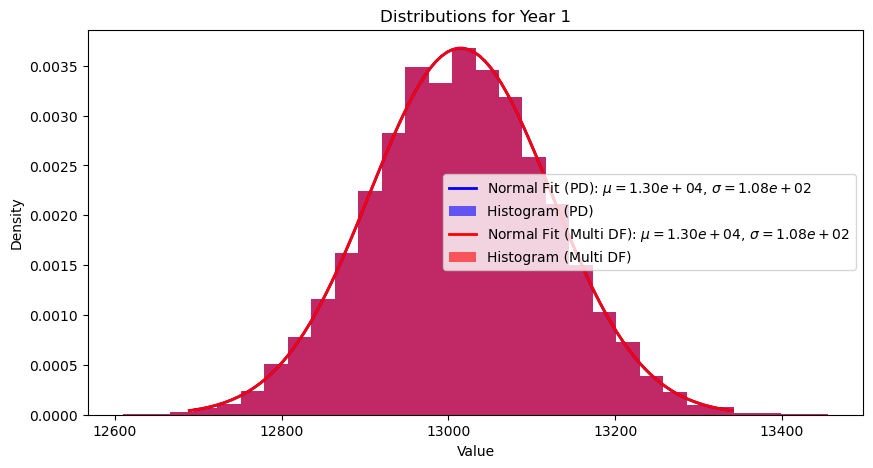

Year 2:
PD - Mean: 17602.41, SD: 128.97, Min: 17031.00, Max: 18093.00
Multi DF - Mean: 17602.41, SD: 128.97, Min: 17031.00, Max: 18093.00


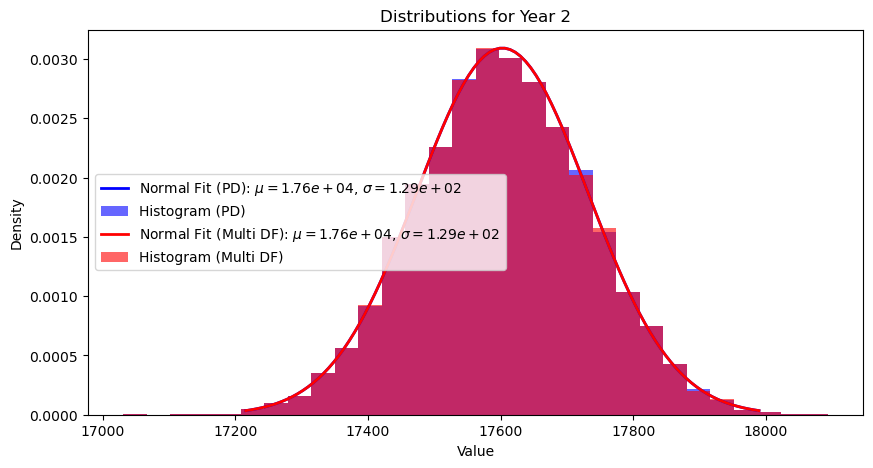

Year 3:
PD - Mean: 20610.59, SD: 140.68, Min: 20069.52, Max: 21112.29
Multi DF - Mean: 20798.20, SD: 141.79, Min: 20252.00, Max: 21305.00


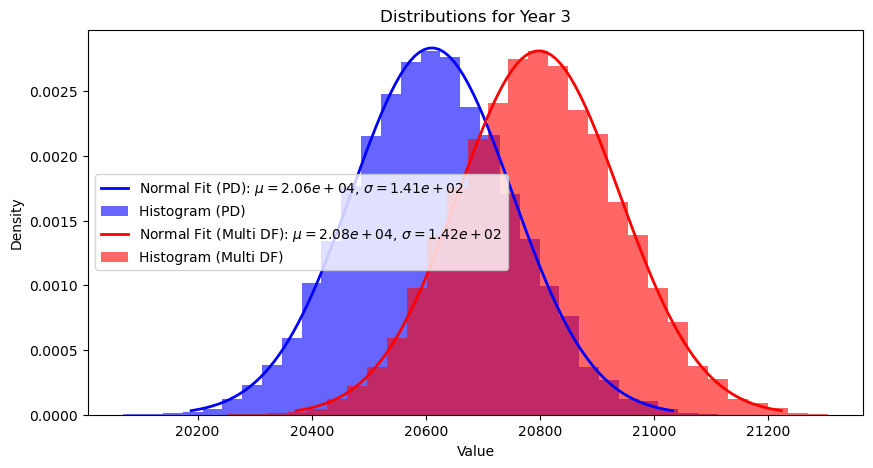

Year 4:
PD - Mean: 22424.02, SD: 148.40, Min: 21892.54, Max: 22971.55
Multi DF - Mean: 22810.66, SD: 150.64, Min: 22276.00, Max: 23370.00


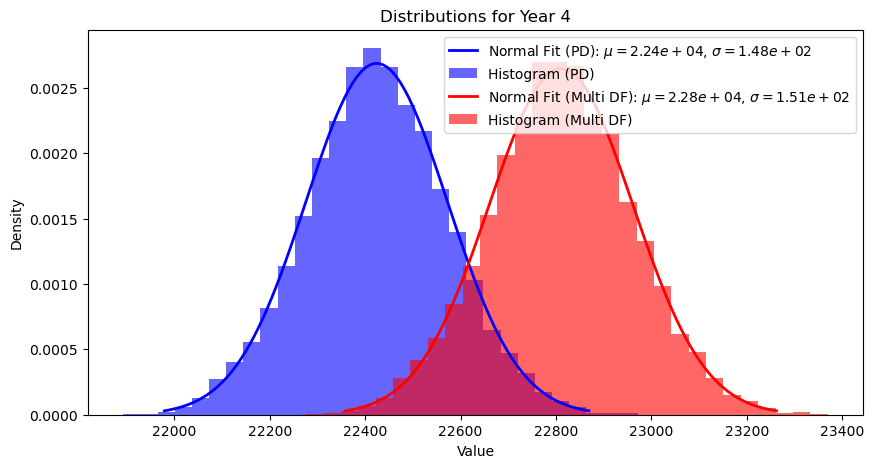

Year 5:
PD - Mean: 23359.12, SD: 150.48, Min: 22742.67, Max: 23961.83
Multi DF - Mean: 23872.53, SD: 153.50, Min: 23246.00, Max: 24497.00


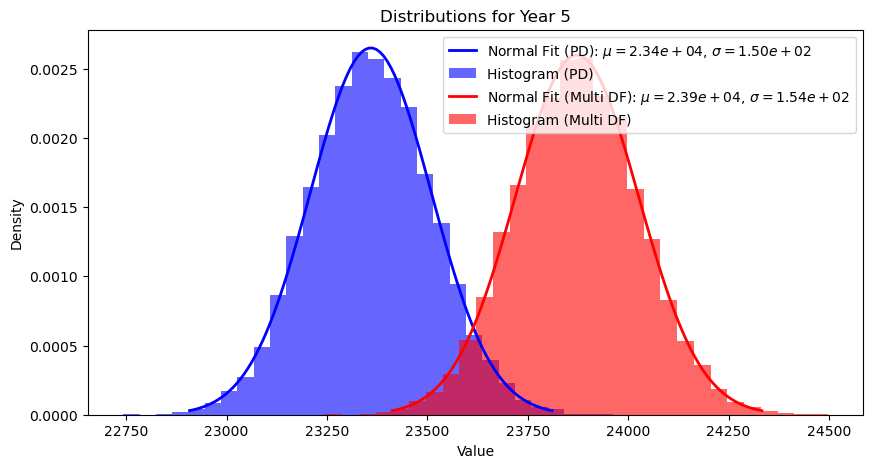

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def simulate_credit_risk(n_simulations=100, year=10, withdraw_prob=0.05):
    n_ratings = 10
    main_diagonal_probs = [0.92, 0.90, 0.87, 0.84, 0.82, 0.80, 0.77, 0.73, 0.68, 0.60]
    n_obligors = [100000, 200000, 300000, 500000, 500000, 400000, 300000, 20000, 10000, 5000]
    
    a = np.repeat(range(1, 11), n_obligors)
    
    # Generate transition matrix
    tm, _ = generate_credit_transition_matrix_with_withdraw_prob(withdraw_prob, main_diagonal_probs)
    
    PD_sums = []
    multi_df_sums = []
    
    for _ in range(n_simulations):
        multi_mat, multi_tm, multi_tm_hf, multi_df, multi_wd = simu_tm_multiyear(a, tm, year+1)
        
        PD = np.zeros((n_ratings, year+1))
        WD = np.zeros((n_ratings, year+1))
        oblg_rm = np.zeros((n_ratings, year+1))
        PD[:,0] = multi_tm[0][:-2,-1]
        WD[:,0] = multi_tm[0][:-2,-2]
        oblg_rm[:,0] = n_obligors
        ctm = multi_tm.copy()                                                                                                
        for j in range(1,year+1):
            ctm[j] = np.matmul(ctm[j-1],multi_tm[j])
            PD[:,j] = (ctm[j][:-2,-1] - ctm[j-1][:-2,-1])/(1-ctm[j-1][:-2,-2])
            WD[:,j] = (ctm[j][:-2,-2] - ctm[j-1][:-2,-2])/(1-ctm[j-1][:-2,-2])
            oblg_rm[:,j] = oblg_rm[:,j-1] - multi_wd[:,j-1]

        t = 5
        PD_sum = sum(PD[:,:t] * oblg_rm[:,:t])
        multi_df_sum = sum(multi_df[:,:t])
        
        PD_sums.append(PD_sum)
        multi_df_sums.append(multi_df_sum)

    return np.array(PD_sums), np.array(multi_df_sums)

# Run simulation and retrieve results
PD_sums, multi_df_sums = simulate_credit_risk(n_simulations=10000)

# Plotting statistics for each period (1 to 5)
for period in range(5):
    # Extract data for the current period
    PD_period = PD_sums[:, period]
    multi_df_period = multi_df_sums[:, period]

    # Calculate statistics
    mean_PD = np.mean(PD_period)
    sd_PD = np.std(PD_period)
    min_PD = np.min(PD_period)
    max_PD = np.max(PD_period)
    
    mean_multi_df = np.mean(multi_df_period)
    sd_multi_df = np.std(multi_df_period)
    min_multi_df = np.min(multi_df_period)
    max_multi_df = np.max(multi_df_period)
    
    print(f"Year {period + 1}:")
    print(f"PD - Mean: {mean_PD:.2f}, SD: {sd_PD:.2f}, Min: {min_PD:.2f}, Max: {max_PD:.2f}")
    print(f"Multi DF - Mean: {mean_multi_df:.2f}, SD: {sd_multi_df:.2f}, Min: {min_multi_df:.2f}, Max: {max_multi_df:.2f}")
    
    # Plotting PD
    plt.figure(figsize=(10, 5))
    
    # Normal distribution for PD
    mu_PD, std_PD = norm.fit(PD_period)
    x_PD = np.linspace(mu_PD - 3*std_PD, mu_PD + 3*std_PD, 100)
    p_PD = norm.pdf(x_PD, mu_PD, std_PD)
    plt.plot(x_PD, p_PD, 'blue', lw=2, label=f'Normal Fit (PD): $\mu={mu_PD:.2e}$, $\sigma={std_PD:.2e}$')
    
    # Histogram for PD
    plt.hist(PD_period, bins=30, density=True, alpha=0.6, color='blue', label='Histogram (PD)')
    
    # Normal distribution for multi_df
    mu_multi_df, std_multi_df = norm.fit(multi_df_period)
    x_multi_df = np.linspace(mu_multi_df - 3*std_multi_df, mu_multi_df + 3*std_multi_df, 100)
    p_multi_df = norm.pdf(x_multi_df, mu_multi_df, std_multi_df)
    plt.plot(x_multi_df, p_multi_df, 'red', lw=2, label=f'Normal Fit (Multi DF): $\mu={mu_multi_df:.2e}$, $\sigma={std_multi_df:.2e}$')
    
    # Histogram for multi_df
    plt.hist(multi_df_period, bins=30, density=True, alpha=0.6, color='red', label='Histogram (Multi DF)')
    
    plt.title(f'Distributions for Year {period + 1}')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

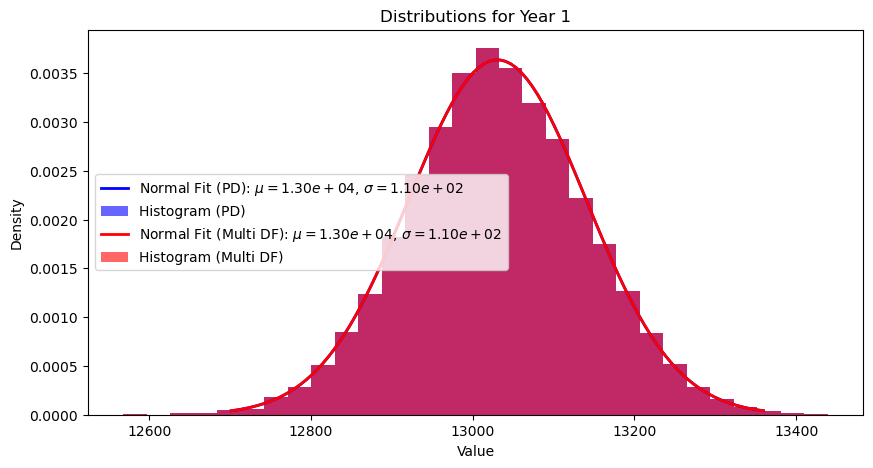

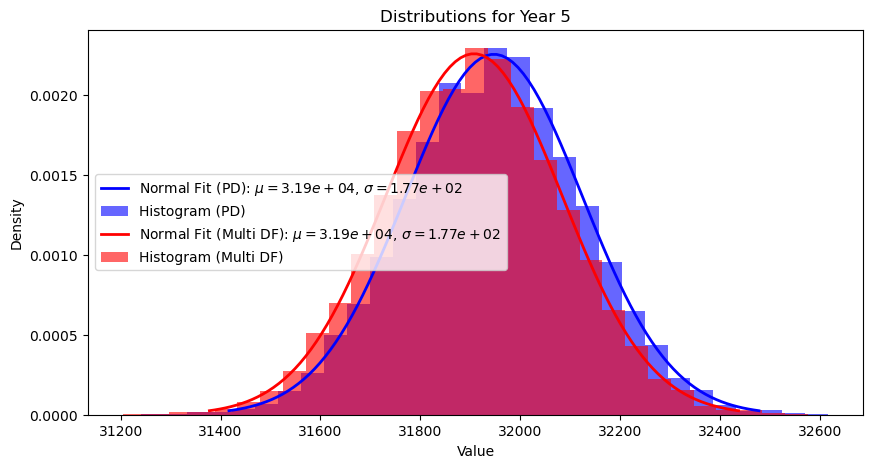

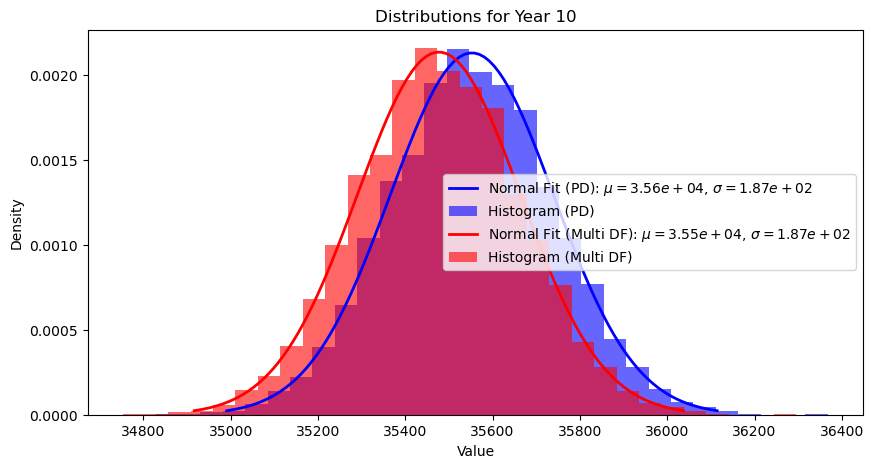

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def simulate_credit_risk(n_simulations=100, year=10, withdraw_prob=0.01):
    n_ratings = 10
    main_diagonal_probs = [0.92, 0.90, 0.87, 0.84, 0.82, 0.80, 0.77, 0.73, 0.68, 0.60]
    n_obligors = [100000, 200000, 300000, 500000, 500000, 400000, 300000, 20000, 10000, 5000]
    
    a = np.repeat(range(1, 11), n_obligors)
    
    # Generate transition matrix
    tm, _ = generate_credit_transition_matrix_with_withdraw_prob(withdraw_prob, main_diagonal_probs)
    
    PD_sums = []
    multi_df_sums = []
    
    for _ in range(n_simulations):
        multi_mat, multi_tm, multi_tm_hf, multi_df, multi_wd = simu_tm_multiyear(a, tm, year+1)
        
        PD = np.zeros((n_ratings, year+1))
        WD = np.zeros((n_ratings, year+1))
        oblg_rm = np.zeros((n_ratings, year+1))
        PD[:,0] = multi_tm[0][:-2,-1]
        WD[:,0] = multi_tm[0][:-2,-2]
        oblg_rm[:,0] = n_obligors
        ctm = multi_tm.copy()                                                                                                
        for j in range(1, year+1):
            ctm[j] = np.matmul(ctm[j-1], multi_tm[j])
            PD[:, j] = (ctm[j][:-2, -1] - ctm[j-1][:-2, -1]) / (1 - ctm[j-1][:-2, -2])
            WD[:, j] = (ctm[j][:-2, -2] - ctm[j-1][:-2, -2]) / (1 - ctm[j-1][:-2, -2])
            oblg_rm[:, j] = oblg_rm[:, j-1] * (1 - WD[:,j])
        
        t = 10
        PD_sum = sum(PD[:,:t] * oblg_rm[:,:t])
        multi_df_sum = sum(multi_df[:,:t])
        
        PD_sums.append(PD_sum)
        multi_df_sums.append(multi_df_sum)

    return np.array(PD_sums), np.array(multi_df_sums)

# Run simulation and retrieve results
PD_sums, multi_df_sums = simulate_credit_risk(n_simulations=10000)

# Plotting statistics for periods 1, 5, and 10
for period in [0, 4, 9]:  # Indices 0, 4, and 9 correspond to periods 1, 5, and 10
    # Extract data for the current period
    PD_period = PD_sums[:, period]
    multi_df_period = multi_df_sums[:, period]

    # Calculate statistics
    mean_PD = np.mean(PD_period)
    sd_PD = np.std(PD_period)
    min_PD = np.min(PD_period)
    max_PD = np.max(PD_period)
    
    mean_multi_df = np.mean(multi_df_period)
    sd_multi_df = np.std(multi_df_period)
    min_multi_df = np.min(multi_df_period)
    max_multi_df = np.max(multi_df_period)
    
    # Plotting PD
    plt.figure(figsize=(10, 5))
    
    # Normal distribution for PD
    mu_PD, std_PD = norm.fit(PD_period)
    x_PD = np.linspace(mu_PD - 3*std_PD, mu_PD + 3*std_PD, 100)
    p_PD = norm.pdf(x_PD, mu_PD, std_PD)
    plt.plot(x_PD, p_PD, 'blue', lw=2, label=f'Normal Fit (PD): $\mu={mu_PD:.2e}$, $\sigma={std_PD:.2e}$')
    
    # Histogram for PD
    plt.hist(PD_period, bins=30, density=True, alpha=0.6, color='blue', label='Histogram (PD)')
    
    # Normal distribution for multi_df
    mu_multi_df, std_multi_df = norm.fit(multi_df_period)
    x_multi_df = np.linspace(mu_multi_df - 3*std_multi_df, mu_multi_df + 3*std_multi_df, 100)
    p_multi_df = norm.pdf(x_multi_df, mu_multi_df, std_multi_df)
    plt.plot(x_multi_df, p_multi_df, 'red', lw=2, label=f'Normal Fit (Multi DF): $\mu={mu_multi_df:.2e}$, $\sigma={std_multi_df:.2e}$')
    
    # Histogram for multi_df
    plt.hist(multi_df_period, bins=30, density=True, alpha=0.6, color='red', label='Histogram (Multi DF)')
    
    plt.title(f'Distributions for Year {period + 1}')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

In [112]:
n_ratings = 10
main_diagonal_probs = [0.83, 0.81, 0.77, 0.74, 0.70, 0.67, 0.63, 0.60, 0.56, 0.52]
n_obligors = [100000, 200000, 300000, 500000, 500000, 400000, 300000, 20000, 10000, 5000]
withdraw_prob = 0.05

a = np.repeat(range(1, 11), n_obligors)

# Generate transition matrix
tm, _ = generate_credit_transition_matrix_with_withdraw_prob(withdraw_prob, main_diagonal_probs)

multi_mat, multi_tm, multi_tm_hf, multi_df, multi_wd = simu_tm_multiyear(a, tm, year+1)

PD = np.zeros((n_ratings, year+1))
WD = np.zeros((n_ratings, year+1))
oblg_rm = np.zeros((n_ratings, year+1))
PD[:,0] = multi_tm[0][:-2,-1]
WD[:,0] = multi_tm[0][:-2,-2]
oblg_rm[:,0] = n_obligors
ctm = multi_tm.copy()                                                                                                
for j in range(1,year+1):
    ctm[j] = np.matmul(ctm[j-1],multi_tm[j])
    PD[:,j] = (ctm[j][:-2,-1] - ctm[j-1][:-2,-1])/(1-ctm[j-1][:-2,-2])
    WD[:,j] = (ctm[j][:-2,-2] - ctm[j-1][:-2,-2])/(1-ctm[j-1][:-2,-2])
    oblg_rm[:,j] = oblg_rm[:,j-1] - multi_wd[:,j-1]

t = 10
PD_sum = sum(PD[:,:t] * oblg_rm[:,:t])
multi_df_sum = sum(multi_df[:,:t])

## Case 2

In [113]:
##Case 2, this test is to try  to find the most accurate way for assumption of mid time withdraw ( Moody’s)
# assume all WD customers only leaves in the middle of each periods and assume LGD = 1 EAD = 1
PD_1 = np.zeros((n_ratings, year*2))
PD_hf = np.zeros((n_ratings, year))
oblg_rm_1 = np.zeros((n_ratings, year*2))
PD_1[:,0] = multi_tm[0][:-2,-1]/2
PD_hf[:,0] = multi_tm_hf[0][:-1,-1]
ctm_hf = multi_tm_hf.copy()
oblg_rm_1[:,0] = n_obligors

for j in range(1,year*2):
    PD_1[:,j] = PD[:,int(j/2)]/2
    oblg_rm_1[:,j] = oblg_rm[:,int(j/2+0.5)]
for j in range(1,year):
    PD_1[:,j*2-1] = PD_1[:,j*2-2]/(1-WD[:,j-1])
    ctm_hf[j] = np.matmul(ctm_hf[j-1],multi_tm_hf[j])
    PD_hf[:,j] = (ctm_hf[j][:-1,-1] - ctm_hf[j-1][:-1,-1])  

t=8
print(sum(PD_1[:,:(t*2)]*oblg_rm_1[:,:(t*2)]),sum(PD_hf[:,:t]*oblg_rm[:,:t]),sum(multi_df[:,:t]))

[ 6526.5         6526.5        11324.5        11083.67962938
 14496.71037382 14208.65575343 16246.02986697 15999.06921608
 17051.31755546 16879.06049129 17355.3203475  17264.76960865
 17007.87590923 16978.21727336 16421.14334616 16436.62104915] [13393.7636542  23271.85572971 29876.66137895 33595.07245177
 35425.80772356 36251.70973527 35747.87056711 34757.16202527] [13053. 22649. 29324. 33090. 34768. 35256. 34319. 32841.]


PD_1 Sum - Mean: 172129.30418985564, SD: 377.7031829175754, Min: 170735.14757915988, Max: 173722.2930032196
PD_hf Sum - Mean: 178727.83680376643, SD: 383.89289812597485, Min: 177417.20654987555, Max: 180265.7512522366
Multi DF Sum - Mean: 175036.4892, SD: 376.0631365653379, Min: 173717.0, Max: 176600.0


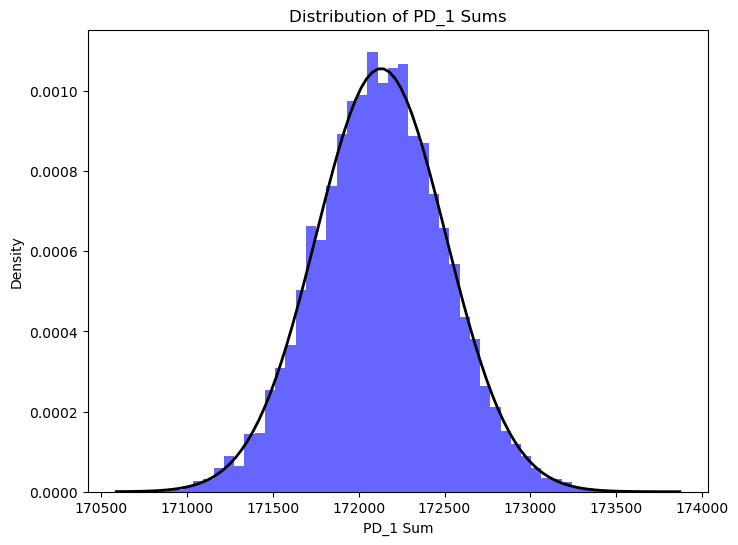

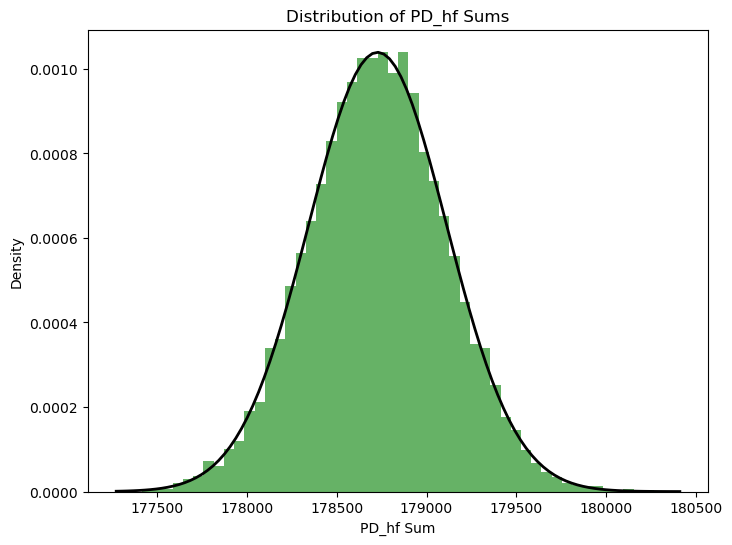

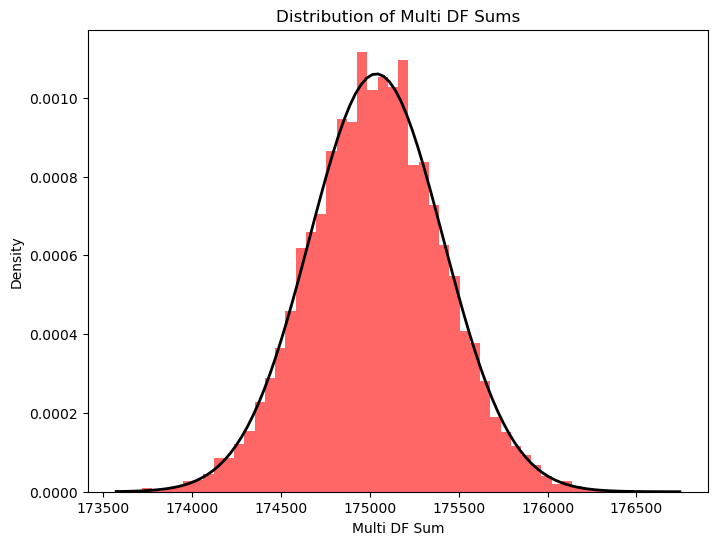

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def simulate_credit_risk_case2(n_simulations=100, year=10, withdraw_prob=0.05):
    n_ratings = 10
    main_diagonal_probs = [0.92, 0.90, 0.87, 0.84, 0.82, 0.80, 0.77, 0.73, 0.68, 0.60]
    n_obligors = [100000, 200000, 300000, 500000, 500000, 400000, 300000, 20000, 10000, 5000]
    
    a = np.repeat(range(1, 11), n_obligors)
    
    # Generate transition matrix
    tm, _ = generate_credit_transition_matrix_with_withdraw_prob(withdraw_prob, main_diagonal_probs)
    
    PD_1_sums = []
    PD_hf_sums = []
    multi_df_sums = []
    
    for _ in range(n_simulations):
        multi_mat, multi_tm, multi_tm_hf, multi_df, multi_wd = simu_tm_multiyear(a, tm, year+1)
        
        PD = np.zeros((n_ratings, year+1))
        WD = np.zeros((n_ratings, year+1))
        oblg_rm = np.zeros((n_ratings, year+1))
        PD[:,0] = multi_tm[0][:-2,-1]
        WD[:,0] = multi_tm[0][:-2,-2]
        oblg_rm[:,0] = n_obligors
        ctm = multi_tm.copy()                                                                                                
        for j in range(1,year+1):
            ctm[j] = np.matmul(ctm[j-1],multi_tm[j])
            PD[:,j] = (ctm[j][:-2,-1] - ctm[j-1][:-2,-1])/(1-ctm[j-1][:-2,-2])
            WD[:,j] = (ctm[j][:-2,-2] - ctm[j-1][:-2,-2])/(1-ctm[j-1][:-2,-2])
            oblg_rm[:,j] = oblg_rm[:,j-1] - multi_wd[:,j-1]

        PD_1 = np.zeros((n_ratings, year*2))
        PD_hf = np.zeros((n_ratings, year))
        oblg_rm_1 = np.zeros((n_ratings, year*2))
        PD_1[:,0] = multi_tm[0][:-2,-1]/2
        PD_hf[:,0] = multi_tm_hf[0][:-1,-1]
        ctm_hf = multi_tm_hf.copy()
        oblg_rm_1[:,0] = n_obligors

        for j in range(1,year*2):
            PD_1[:,j] = PD[:,int(j/2)]/2
            oblg_rm_1[:,j] = oblg_rm[:,int(j/2+0.5)]
        for j in range(1,year):
            PD_1[:,j*2-1] = PD_1[:,j*2-2]/(1-WD[:,j-1])
            ctm_hf[j] = np.matmul(ctm_hf[j-1],multi_tm_hf[j])
            PD_hf[:,j] = (ctm_hf[j][:-1,-1] - ctm_hf[j-1][:-1,-1])

        t=8
        PD_1_sum = np.sum(PD_1[:,:(t*2)] * oblg_rm_1[:,:(t*2)])
        PD_hf_sum = np.sum(PD_hf[:,:t] * oblg_rm[:,:t])
        multi_df_sum = np.sum(multi_df[:,:t])
        
        PD_1_sums.append(PD_1_sum)
        PD_hf_sums.append(PD_hf_sum)
        multi_df_sums.append(multi_df_sum)
    
    # Convert to numpy arrays for easier calculations
    PD_1_sums = np.array(PD_1_sums)
    PD_hf_sums = np.array(PD_hf_sums)
    multi_df_sums = np.array(multi_df_sums)
    
    # Calculate statistics
    mean_PD_1_sum = np.mean(PD_1_sums)
    sd_PD_1_sum = np.std(PD_1_sums)
    min_PD_1_sum = np.min(PD_1_sums)
    max_PD_1_sum = np.max(PD_1_sums)
    
    mean_PD_hf_sum = np.mean(PD_hf_sums)
    sd_PD_hf_sum = np.std(PD_hf_sums)
    min_PD_hf_sum = np.min(PD_hf_sums)
    max_PD_hf_sum = np.max(PD_hf_sums)
    
    mean_multi_df_sum = np.mean(multi_df_sums)
    sd_multi_df_sum = np.std(multi_df_sums)
    min_multi_df_sum = np.min(multi_df_sums)
    max_multi_df_sum = np.max(multi_df_sums)
    
    # Print statistics
    print(f"PD_1 Sum - Mean: {mean_PD_1_sum}, SD: {sd_PD_1_sum}, Min: {min_PD_1_sum}, Max: {max_PD_1_sum}")
    print(f"PD_hf Sum - Mean: {mean_PD_hf_sum}, SD: {sd_PD_hf_sum}, Min: {min_PD_hf_sum}, Max: {max_PD_hf_sum}")
    print(f"Multi DF Sum - Mean: {mean_multi_df_sum}, SD: {sd_multi_df_sum}, Min: {min_multi_df_sum}, Max: {max_multi_df_sum}")
    
    # Plotting the distributions with normal distribution overlay
    
    # PD_1 Sum
    plt.figure(figsize=(8, 6))
    plt.hist(PD_1_sums, bins=50, alpha=0.6, color='blue', density=True)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mean_PD_1_sum, sd_PD_1_sum)
    plt.plot(x, p, 'k', linewidth=2)
    plt.title("Distribution of PD_1 Sums")
    plt.xlabel("PD_1 Sum")
    plt.ylabel("Density")
    plt.show()

    # PD_hf Sum
    plt.figure(figsize=(8, 6))
    plt.hist(PD_hf_sums, bins=50, alpha=0.6, color='green', density=True)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mean_PD_hf_sum, sd_PD_hf_sum)
    plt.plot(x, p, 'k', linewidth=2)
    plt.title("Distribution of PD_hf Sums")
    plt.xlabel("PD_hf Sum")
    plt.ylabel("Density")
    plt.show()

    # Multi DF Sum
    plt.figure(figsize=(8, 6))
    plt.hist(multi_df_sums, bins=50, alpha=0.6, color='red', density=True)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mean_multi_df_sum, sd_multi_df_sum)
    plt.plot(x, p, 'k', linewidth=2)
    plt.title("Distribution of Multi DF Sums")
    plt.xlabel("Multi DF Sum")
    plt.ylabel("Density")
    plt.show()

    return (mean_PD_1_sum, sd_PD_1_sum, min_PD_1_sum, max_PD_1_sum,
            mean_PD_hf_sum, sd_PD_hf_sum, min_PD_hf_sum, max_PD_hf_sum,
            mean_multi_df_sum, sd_multi_df_sum, min_multi_df_sum, max_multi_df_sum)

# Run simulation
(mean_PD_1_sum, sd_PD_1_sum, min_PD_1_sum, max_PD_1_sum,
 mean_PD_hf_sum, sd_PD_hf_sum, min_PD_hf_sum, max_PD_hf_sum,
 mean_multi_df_sum, sd_multi_df_sum, min_multi_df_sum, max_multi_df_sum) = simulate_credit_risk_case2(n_simulations=10000)

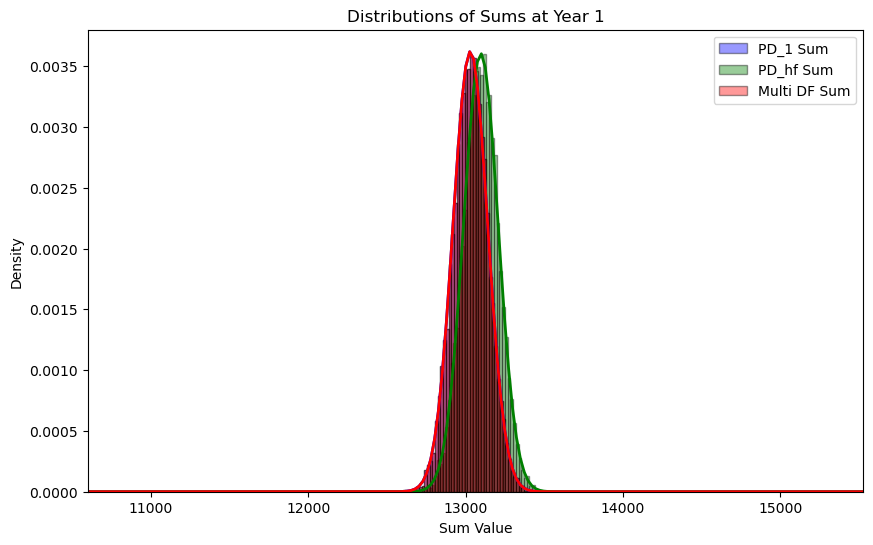

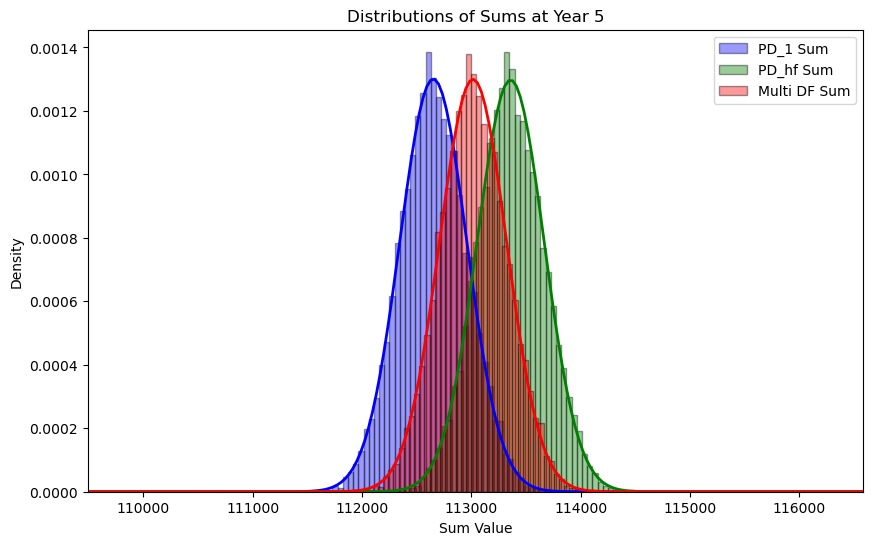

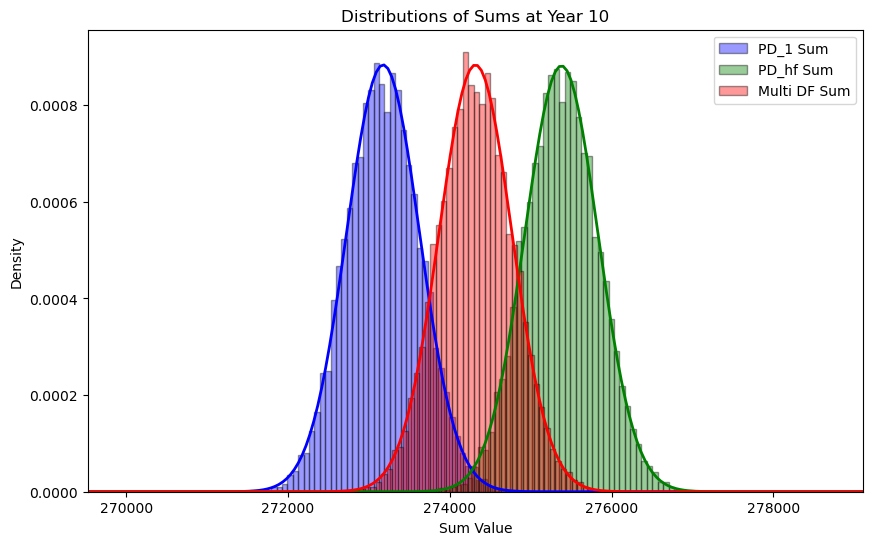

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def simulate_credit_risk_case2(n_simulations=100, year=10, withdraw_prob=0.01):
    n_ratings = 10
    main_diagonal_probs = [0.94, 0.92, 0.89, 0.86, 0.84, 0.82, 0.77, 0.73, 0.68, 0.60]
    n_obligors = [100000, 200000, 300000, 500000, 500000, 400000, 300000, 20000, 10000, 5000]
    
    a = np.repeat(range(1, 11), n_obligors)
    
    # Generate transition matrix
    tm, _ = generate_credit_transition_matrix_with_withdraw_prob(withdraw_prob, main_diagonal_probs)
    
    PD_1_sums = {1: [], 5: [], 10: []}
    PD_hf_sums = {1: [], 5: [], 10: []}
    multi_df_sums = {1: [], 5: [], 10: []}
    
    for _ in range(n_simulations):
        multi_mat, multi_tm, multi_tm_hf, multi_df, multi_wd = simu_tm_multiyear(a, tm, year+1)
        
        PD = np.zeros((n_ratings, year+1))
        WD = np.zeros((n_ratings, year+1))
        oblg_rm = np.zeros((n_ratings, year+1))
        PD[:,0] = multi_tm[0][:-2,-1]
        WD[:,0] = multi_tm[0][:-2,-2]
        oblg_rm[:,0] = n_obligors
        ctm = multi_tm.copy()                                                                                                
        for j in range(1,year+1):
            ctm[j] = np.matmul(ctm[j-1],multi_tm[j])
            PD[:,j] = (ctm[j][:-2,-1] - ctm[j-1][:-2,-1])/(1-ctm[j-1][:-2,-2])
            WD[:,j] = (ctm[j][:-2,-2] - ctm[j-1][:-2,-2])/(1-ctm[j-1][:-2,-2])
            oblg_rm[:,j] = oblg_rm[:,j-1] - multi_wd[:,j-1]

        PD_1 = np.zeros((n_ratings, year*2))
        PD_hf = np.zeros((n_ratings, year))
        oblg_rm_1 = np.zeros((n_ratings, year*2))
        PD_1[:,0] = multi_tm[0][:-2,-1]/2
        PD_hf[:,0] = multi_tm_hf[0][:-1,-1]
        ctm_hf = multi_tm_hf.copy()
        oblg_rm_1[:,0] = n_obligors

        for j in range(1,year*2):
            PD_1[:,j] = PD[:,int(j/2)]/2
            oblg_rm_1[:,j] = oblg_rm[:,int(j/2+0.5)]
        for j in range(1,year):
            PD_1[:,j*2-1] = PD_1[:,j*2-2]/(1-WD[:,j-1])
            ctm_hf[j] = np.matmul(ctm_hf[j-1],multi_tm_hf[j])
            PD_hf[:,j] = (ctm_hf[j][:-1,-1] - ctm_hf[j-1][:-1,-1])

        for t in [1, 5, 10]:  # For times 1, 5, and 10
            PD_1_sum = np.sum(PD_1[:,:(t*2)] * oblg_rm_1[:,:(t*2)])
            PD_hf_sum = np.sum(PD_hf[:,:t] * oblg_rm[:,:t])
            multi_df_sum = np.sum(multi_df[:,:t])
            
            PD_1_sums[t].append(PD_1_sum)
            PD_hf_sums[t].append(PD_hf_sum)
            multi_df_sums[t].append(multi_df_sum)
    
    # Convert to numpy arrays for easier calculations
    for t in [1, 5, 10]:
        PD_1_sums[t] = np.array(PD_1_sums[t])
        PD_hf_sums[t] = np.array(PD_hf_sums[t])
        multi_df_sums[t] = np.array(multi_df_sums[t])
        
    # Plotting the distributions for times 1, 5, and 10 in the same plot for comparison

    for t in [1, 5, 10]:
        plt.figure(figsize=(10, 6))

        # PD_1 Sum
        plt.hist(PD_1_sums[t], bins=50, alpha=0.4, color='blue', density=True, label='PD_1 Sum', edgecolor='black')
        xmin = min(np.min(PD_1_sums[t]), np.min(PD_hf_sums[t]), np.min(multi_df_sums[t])) - 2000
        xmax = max(np.max(PD_1_sums[t]), np.max(PD_hf_sums[t]), np.max(multi_df_sums[t])) + 2000
        x = np.linspace(xmin, xmax, 200)
        p = norm.pdf(x, np.mean(PD_1_sums[t]), np.std(PD_1_sums[t]))
        plt.plot(x, p, 'blue', linewidth=2)

        # PD_hf Sum
        plt.hist(PD_hf_sums[t], bins=50, alpha=0.4, color='green', density=True, label='PD_hf Sum', edgecolor='black')
        p = norm.pdf(x, np.mean(PD_hf_sums[t]), np.std(PD_hf_sums[t]))
        plt.plot(x, p, 'green', linewidth=2)

        # Multi DF Sum
        plt.hist(multi_df_sums[t], bins=50, alpha=0.4, color='red', density=True, label='Multi DF Sum', edgecolor='black')
        p = norm.pdf(x, np.mean(multi_df_sums[t]), np.std(multi_df_sums[t]))
        plt.plot(x, p, 'red', linewidth=2)

        # Adjust x-axis limits to ensure all curves are fully displayed
        plt.xlim([xmin, xmax])

        plt.title(f"Distributions of Sums at Year {t}")
        plt.xlabel("Sum Value")
        plt.ylabel("Density")
        plt.legend()
        plt.show()


    return (PD_1_sums, PD_hf_sums, multi_df_sums)

# Run simulation
PD_1_sums, PD_hf_sums, multi_df_sums = simulate_credit_risk_case2(n_simulations=10000)

## Case 3

In [114]:
### Case 3 Simulation based on real world
### when the model is applied, only long run average TM can be used instead of PIT TM(without macro)
TM_l = np.mean(multi_tm, axis = 0)
pred_ctm_fwd, pred_ctm_fwd_hf = forward_tm_multiyear(TM_l, year)

# assume all WD customers only leaves in the middle of each periods and assume LGD = 1 EAD = 1
PD_2 = np.zeros((n_ratings, year*2))
PD_2_hf = np.zeros((n_ratings, year))
PD_2[:,0] = pred_ctm_fwd[0][:-2,-1]/2
PD_2_hf[:,0] = pred_ctm_fwd_hf[0][:-1,-1]

PD_m_2 = np.zeros((n_ratings, year+1))
WD_m_2 = np.zeros((n_ratings, year+1))

PD_m_2[:,0] = pred_ctm_fwd[0][:-2,-1]
for j in range(1,year+1):
    PD_m_2[:,j] = (pred_ctm_fwd[j][:-2,-1] - pred_ctm_fwd[j-1][:-2,-1])/(1-pred_ctm_fwd[j-1][:-2,-2])
    WD_m_2[:,j] = (pred_ctm_fwd[j][:-2,-2] - pred_ctm_fwd[j-1][:-2,-2])/(1-pred_ctm_fwd[j-1][:-2,-2])

for j in range(1,year*2):
    PD_2[:,j] = PD_m_2[:,int(j/2)]/2
for j in range(1,year):
    PD_2[:,j*2-1] = PD_2[:,j*2-2]/(1-WD_m_2[:,j-1])
    PD_2_hf[:,j] = (pred_ctm_fwd_hf[j][:-1,-1] - pred_ctm_fwd_hf[j-1][:-1,-1])  

t=10

ecl1_tmp = PD_2[:,:(t*2)]*oblg_rm_1[:,:(t*2)]
ecl1 = np.zeros((n_ratings, year))
for j in range(year):
    ecl1[:,j] = ecl1_tmp[:,2*j] + ecl1_tmp[:,2*j+1]
ecl1_hf = PD_2_hf[:,:t]*oblg_rm[:,:t]
loss = multi_df[:,:t]

print(sum(ecl1)/sum(loss)-1,sum(ecl1_hf)/sum(loss)-1)

[-0.02496396 -0.01403847 -0.02655035 -0.0263352  -0.02252889 -0.02418849
 -0.01233508 -0.00187509  0.02389877  0.00805338] [0.02655156 0.02805489 0.01860109 0.02010174 0.02591933 0.02707355
 0.04457749 0.06215999 0.09836161 0.11368817]


In [184]:
sum(multi_df[:,:t])

array([13137., 18865., 23061., 26329., 28234., 30177., 30677., 31299.,
       31340., 31018.])

In [185]:
multi_df[:,:t]

array([[5.0000e+00, 4.0000e+00, 4.0000e+00, 3.0000e+00, 8.0000e+00,
        6.0000e+00, 7.0000e+00, 7.0000e+00, 6.0000e+00, 8.0000e+00],
       [2.2000e+01, 2.0000e+01, 2.2000e+01, 3.0000e+01, 1.9000e+01,
        2.1000e+01, 2.6000e+01, 2.5000e+01, 1.9000e+01, 2.8000e+01],
       [1.3100e+02, 1.0700e+02, 1.0200e+02, 1.0700e+02, 1.0500e+02,
        1.1600e+02, 1.3700e+02, 9.2000e+01, 1.0900e+02, 9.6000e+01],
       [4.3000e+02, 4.2300e+02, 4.3300e+02, 4.0700e+02, 3.5800e+02,
        3.6200e+02, 3.3900e+02, 3.3500e+02, 3.0600e+02, 3.1500e+02],
       [1.2640e+03, 1.1480e+03, 1.1770e+03, 1.1050e+03, 1.0170e+03,
        9.1000e+02, 9.1400e+02, 9.0300e+02, 8.3700e+02, 8.0800e+02],
       [2.7740e+03, 2.6020e+03, 2.4320e+03, 2.3380e+03, 2.1800e+03,
        2.0160e+03, 1.9330e+03, 1.8490e+03, 1.7400e+03, 1.6240e+03],
       [3.9570e+03, 3.5720e+03, 3.1990e+03, 2.9840e+03, 2.8670e+03,
        2.7740e+03, 2.5480e+03, 2.4450e+03, 2.3500e+03, 2.0850e+03],
       [1.1960e+03, 3.2060e+03, 4.4780e+0

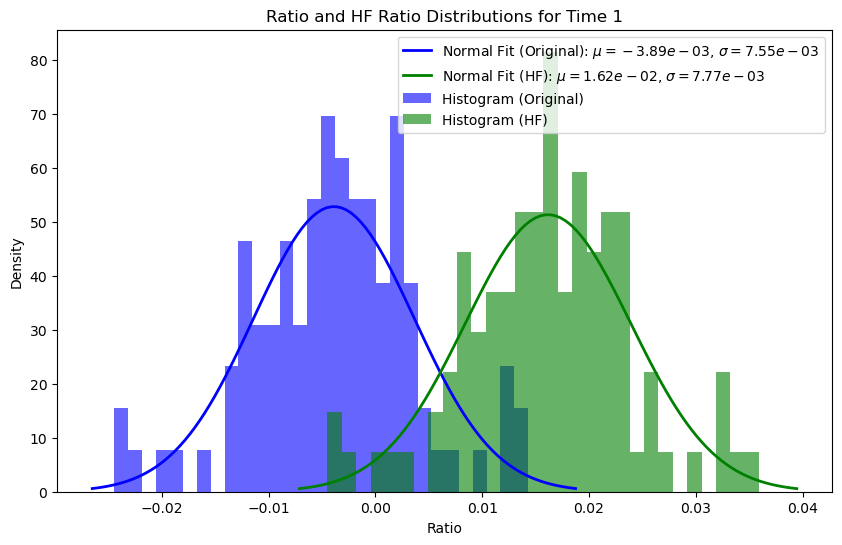

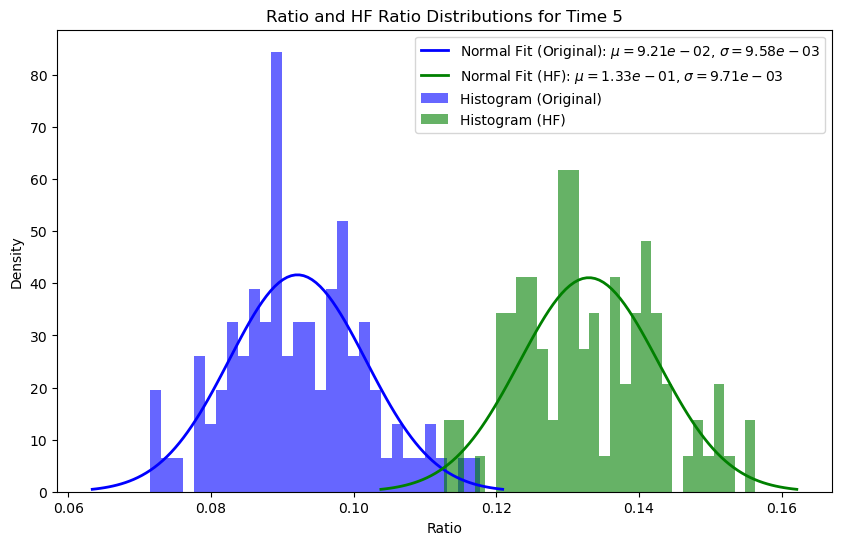

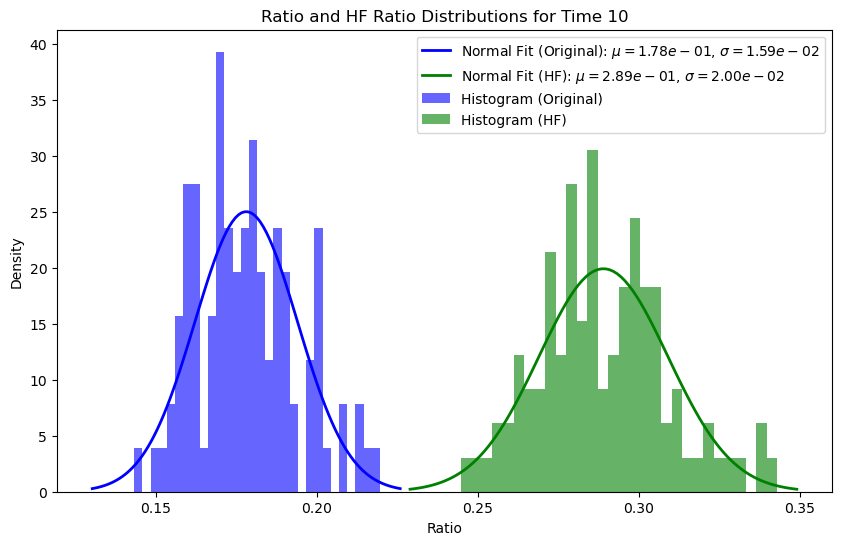

In [97]:
def simulate_credit_risk_case3(n_simulations=100, year=10, withdraw_prob=0.03):
    n_ratings = 10
    main_diagonal_probs = [0.94, 0.92, 0.89, 0.86, 0.84, 0.82, 0.77, 0.73, 0.68, 0.60]
    n_obligors = [100000, 200000, 300000, 500000, 500000, 400000, 300000, 20000, 10000, 5000]
    
    ratios = []
    ratios_hf = []
    
    for _ in range(n_simulations):
        # Generate transition matrix
        tm, _ = generate_credit_transition_matrix_with_withdraw_prob(withdraw_prob, main_diagonal_probs)
        
        multi_mat, multi_tm, multi_tm_hf, multi_df, multi_wd = simu_tm_multiyear(a, tm, year+1)
        
        # Calculate long-run average TM
        TM_l = np.mean(multi_tm, axis=0)
        
        # Generate forward transition matrices using the long-run average TM
        pred_ctm_fwd, pred_ctm_fwd_hf = forward_tm_multiyear(TM_l, year)
        
        # Initialize PD and WD matrices
        PD_2 = np.zeros((n_ratings, year*2))
        PD_2_hf = np.zeros((n_ratings, year))
        PD_2[:,0] = pred_ctm_fwd[0][:-2,-1]/2
        PD_2_hf[:,0] = pred_ctm_fwd_hf[0][:-1,-1]
        
        PD_m_2 = np.zeros((n_ratings, year+1))
        WD_m_2 = np.zeros((n_ratings, year+1))
        
        PD_m_2[:,0] = pred_ctm_fwd[0][:-2,-1]
        for j in range(1, year+1):
            PD_m_2[:,j] = (pred_ctm_fwd[j][:-2,-1] - pred_ctm_fwd[j-1][:-2,-1]) / (1 - pred_ctm_fwd[j-1][:-2,-2])
            WD_m_2[:,j] = (pred_ctm_fwd[j][:-2,-2] - pred_ctm_fwd[j-1][:-2,-2]) / (1 - pred_ctm_fwd[j-1][:-2,-2])

        # Calculate PD_2 and PD_2_hf for each half-year and full year
        for j in range(1, year*2):
            PD_2[:,j] = PD_m_2[:,int(j/2)]/2
        for j in range(1, year):
            PD_2[:,j*2-1] = PD_2[:,j*2-2] / (1 - WD_m_2[:,j-1])
            PD_2_hf[:,j] = (pred_ctm_fwd_hf[j][:-1,-1] - pred_ctm_fwd_hf[j-1][:-1,-1])

        # Compute ECLs
        oblg_rm_1 = np.zeros((n_ratings, year*2))
        oblg_rm_1[:,0] = n_obligors
        for j in range(1, year*2):
            oblg_rm_1[:,j] = oblg_rm[:,int(j/2+0.5)]
        
        t = 10
        ecl1_tmp = PD_2[:,:(t*2)] * oblg_rm_1[:,:(t*2)]
        ecl1 = np.zeros((n_ratings, year))
        for j in range(year):
            ecl1[:,j] = ecl1_tmp[:,2*j] + ecl1_tmp[:,2*j+1]
        ecl1_hf = PD_2_hf[:,:t] * oblg_rm_1[:,:t]
        loss = multi_df[:,:t]

        # Calculate the overall ratios directly
        ratio = sum(ecl1) / sum(loss) - 1
        ratio_hf = sum(ecl1_hf) / sum(loss) - 1
        
        ratios.append(ratio)
        ratios_hf.append(ratio_hf)

    # Convert to numpy arrays for easier calculations
    ratios = np.array(ratios)
    ratios_hf = np.array(ratios_hf)
    
    # Plot individual statistics for times 1, 5, and 10
    for i in [0, 4, 9]:  # Corresponding to time 1, time 5, and time 10 (index is 0-based)
        plt.figure(figsize=(10, 6))
        
        # Fit normal distribution for ratios and ratios_hf
        mu_ratio, std_ratio = norm.fit(ratios[:, i])
        mu_ratio_hf, std_ratio_hf = norm.fit(ratios_hf[:, i])
        
        # Plot normal distribution for ratios
        x = np.linspace(mu_ratio - 3*std_ratio, mu_ratio + 3*std_ratio, 100)
        p = norm.pdf(x, mu_ratio, std_ratio)
        plt.plot(x, p, 'blue', lw=2, label=f'Normal Fit (Original): $\mu={mu_ratio:.2e}$, $\sigma={std_ratio:.2e}$')
        
        # Plot normal distribution for ratios_hf
        x_hf = np.linspace(mu_ratio_hf - 3*std_ratio_hf, mu_ratio_hf + 3*std_ratio_hf, 100)
        p_hf = norm.pdf(x_hf, mu_ratio_hf, std_ratio_hf)
        plt.plot(x_hf, p_hf, 'green', lw=2, label=f'Normal Fit (HF): $\mu={mu_ratio_hf:.2e}$, $\sigma={std_ratio_hf:.2e}$')
        
        # Plot histogram for ratios
        plt.hist(ratios[:, i], bins=30, density=True, alpha=0.6, color='blue', label='Histogram (Original)')
        
        # Plot histogram for ratios_hf
        plt.hist(ratios_hf[:, i], bins=30, density=True, alpha=0.6, color='green', label='Histogram (HF)')
        
        plt.title(f'Ratio and HF Ratio Distributions for Time {i+1}')
        plt.xlabel('Ratio')
        plt.ylabel('Density')
        plt.legend()
        plt.show()
    
    return (PD_2, PD_m_2), (mu_ratio, std_ratio), (mu_ratio_hf, std_ratio_hf)

# Run simulation and plot results
(PD_2, PD_m_2), (mu_ratio, std_ratio), (mu_ratio_hf, std_ratio_hf) = simulate_credit_risk_case3(n_simulations=100)

In [93]:
withdraw_prob=0.05
main_diagonal_probs = [0.87, 0.83, 0.80, 0.77, 0.73, 0.70, 0.67, 0.63, 0.58, 0.53]
tm, _ = generate_credit_transition_matrix_with_withdraw_prob(withdraw_prob, main_diagonal_probs)


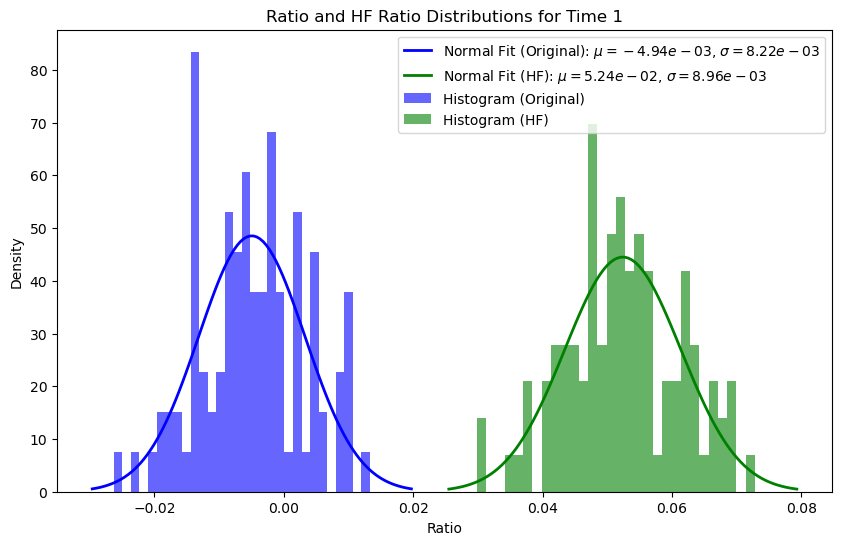

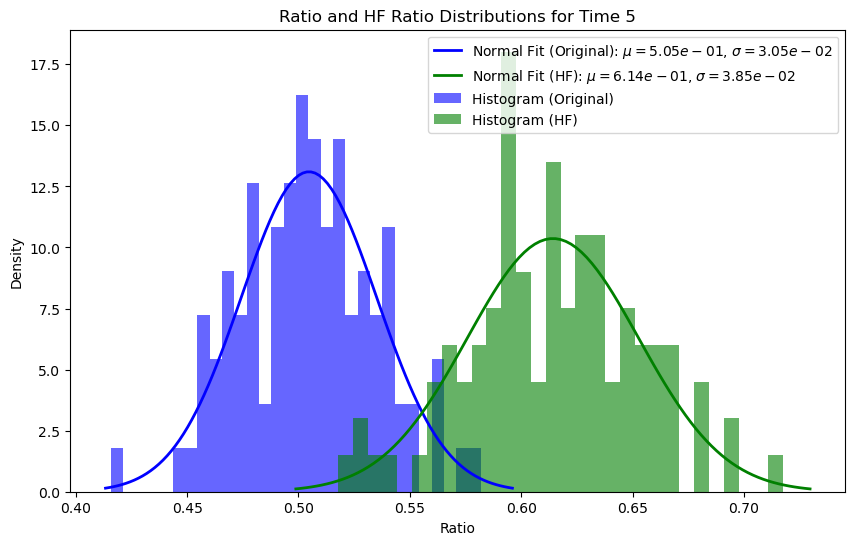

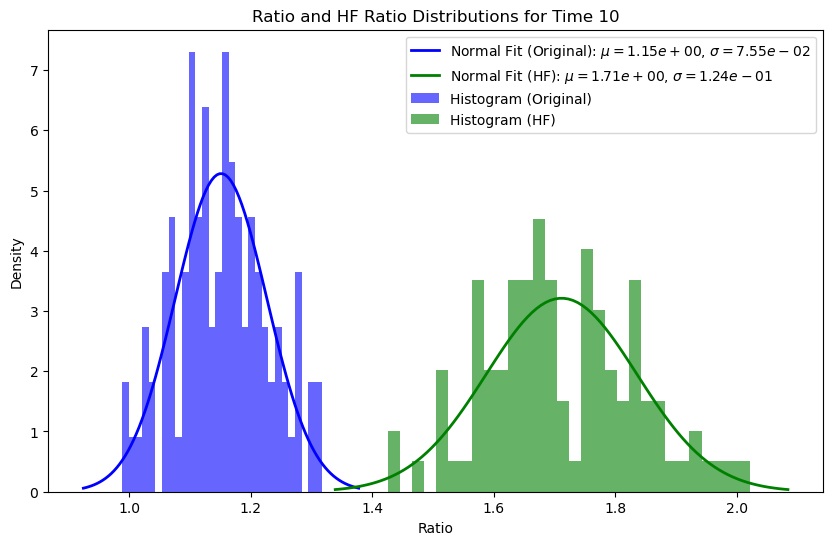

In [104]:
def simulate_credit_risk_case3(n_simulations=100, year=10, withdraw_prob=0.1):
    n_ratings = 10
    main_diagonal_probs = [0.83, 0.81, 0.77, 0.74, 0.70, 0.67, 0.63, 0.60, 0.56, 0.52]
    n_obligors = [100000, 200000, 300000, 500000, 500000, 400000, 300000, 20000, 10000, 5000]
    
    ratios = []
    ratios_hf = []
    
    for _ in range(n_simulations):
        valid_tm = False
        while not valid_tm:
            # Generate transition matrix
            tm, _ = generate_credit_transition_matrix_with_withdraw_prob(withdraw_prob, main_diagonal_probs)
            
            # Check if the transition matrix is valid
            if np.all(np.isfinite(tm)) and np.all(tm >= 0) and np.all(tm <= 1) and np.allclose(tm.sum(axis=1), 1):
                valid_tm = True  # If the matrix passes all checks, it's valid and we can proceed

        multi_mat, multi_tm, multi_tm_hf, multi_df, multi_wd = simu_tm_multiyear(a, tm, year+1)
        
        # Calculate long-run average TM
        TM_l = np.mean(multi_tm, axis=0)
        
        # Generate forward transition matrices using the long-run average TM
        pred_ctm_fwd, pred_ctm_fwd_hf = forward_tm_multiyear(TM_l, year)
        
        # Initialize PD and WD matrices
        PD_2 = np.zeros((n_ratings, year*2))
        PD_2_hf = np.zeros((n_ratings, year))
        PD_2[:,0] = pred_ctm_fwd[0][:-2,-1]/2
        PD_2_hf[:,0] = pred_ctm_fwd_hf[0][:-1,-1]
        
        PD_m_2 = np.zeros((n_ratings, year+1))
        WD_m_2 = np.zeros((n_ratings, year+1))
        
        PD_m_2[:,0] = pred_ctm_fwd[0][:-2,-1]
        for j in range(1, year+1):
            PD_m_2[:,j] = (pred_ctm_fwd[j][:-2,-1] - pred_ctm_fwd[j-1][:-2,-1]) / (1 - pred_ctm_fwd[j-1][:-2,-2])
            WD_m_2[:,j] = (pred_ctm_fwd[j][:-2,-2] - pred_ctm_fwd[j-1][:-2,-2]) / (1 - pred_ctm_fwd[j-1][:-2,-2])

        # Calculate PD_2 and PD_2_hf for each half-year and full year
        for j in range(1, year*2):
            PD_2[:,j] = PD_m_2[:,int(j/2)]/2
        for j in range(1, year):
            PD_2[:,j*2-1] = PD_2[:,j*2-2] / (1 - WD_m_2[:,j-1])
            PD_2_hf[:,j] = (pred_ctm_fwd_hf[j][:-1,-1] - pred_ctm_fwd_hf[j-1][:-1,-1])

        # Compute ECLs
        oblg_rm_1 = np.zeros((n_ratings, year*2))
        oblg_rm_1[:,0] = n_obligors
        for j in range(1, year*2):
            oblg_rm_1[:,j] = oblg_rm[:,int(j/2+0.5)]
        
        t = 10
        ecl1_tmp = PD_2[:,:(t*2)] * oblg_rm_1[:,:(t*2)]
        ecl1 = np.zeros((n_ratings, year))
        for j in range(year):
            ecl1[:,j] = ecl1_tmp[:,2*j] + ecl1_tmp[:,2*j+1]
        ecl1_hf = PD_2_hf[:,:t] * oblg_rm_1[:,:t]
        loss = multi_df[:,:t]

        # Calculate the overall ratios directly
        ratio = sum(ecl1) / sum(loss) - 1
        ratio_hf = sum(ecl1_hf) / sum(loss) - 1
        
        ratios.append(ratio)
        ratios_hf.append(ratio_hf)

    # Convert to numpy arrays for easier calculations
    ratios = np.array(ratios)
    ratios_hf = np.array(ratios_hf)
    
    # Plot individual statistics for times 1, 5, and 10
    for i in [0, 4, 9]:  # Corresponding to time 1, time 5, and time 10 (index is 0-based)
        plt.figure(figsize=(10, 6))
        
        # Fit normal distribution for ratios and ratios_hf
        mu_ratio, std_ratio = norm.fit(ratios[:, i])
        mu_ratio_hf, std_ratio_hf = norm.fit(ratios_hf[:, i])
        
        # Plot normal distribution for ratios
        x = np.linspace(mu_ratio - 3*std_ratio, mu_ratio + 3*std_ratio, 100)
        p = norm.pdf(x, mu_ratio, std_ratio)
        plt.plot(x, p, 'blue', lw=2, label=f'Normal Fit (Original): $\mu={mu_ratio:.2e}$, $\sigma={std_ratio:.2e}$')
        
        # Plot normal distribution for ratios_hf
        x_hf = np.linspace(mu_ratio_hf - 3*std_ratio_hf, mu_ratio_hf + 3*std_ratio_hf, 100)
        p_hf = norm.pdf(x_hf, mu_ratio_hf, std_ratio_hf)
        plt.plot(x_hf, p_hf, 'green', lw=2, label=f'Normal Fit (HF): $\mu={mu_ratio_hf:.2e}$, $\sigma={std_ratio_hf:.2e}$')
        
        # Plot histogram for ratios
        plt.hist(ratios[:, i], bins=30, density=True, alpha=0.6, color='blue', label='Histogram (Original)')
        
        # Plot histogram for ratios_hf
        plt.hist(ratios_hf[:, i], bins=30, density=True, alpha=0.6, color='green', label='Histogram (HF)')
        
        plt.title(f'Ratio and HF Ratio Distributions for Time {i+1}')
        plt.xlabel('Ratio')
        plt.ylabel('Density')
        plt.legend()
        plt.show()
    
    return (PD_2, PD_m_2), (mu_ratio, std_ratio), (mu_ratio_hf, std_ratio_hf)

# Run simulation and plot results
(PD_2, PD_m_2), (mu_ratio, std_ratio), (mu_ratio_hf, std_ratio_hf) = simulate_credit_risk_case3(n_simulations=100)

In [95]:
tm[:, -1]

array([5.000e-05, 1.000e-04, 4.000e-04, 9.000e-04, 2.500e-03, 7.000e-03,
       1.280e-02, 6.010e-02, 1.575e-01, 3.537e-01])